## Text Classification EDA

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np

In [1]:
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet

from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
# This tokenizer divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation 
# words, collocations, and words that start sentences. It must be trained on a large collection of plaintext in the target 
# language before it can be used.

nltk.download('averaged_perceptron_tagger')
# punkt is used for tokenising sentences and averaged_perceptron_tagger is used for tagging words with their parts of speech 
# (POS). We also need to set the add this directory to the NLTK data path

nltk.download('wordnet')
# To find the meanings of words, synonyms, antonyms, and more.
# WordNet is a lexical database of the English language that relates words to one another in terms of synonyms, hypernyms 
# (more abstract terms), hyponyms (more specific terms), and meronyms (part-whole relationships). It is a large, comprehensive 
# lexical database that has been widely used in natural language processing and computational linguistics

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aicyb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aicyb\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aicyb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
#for model-building

from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [8]:
# bag of words

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

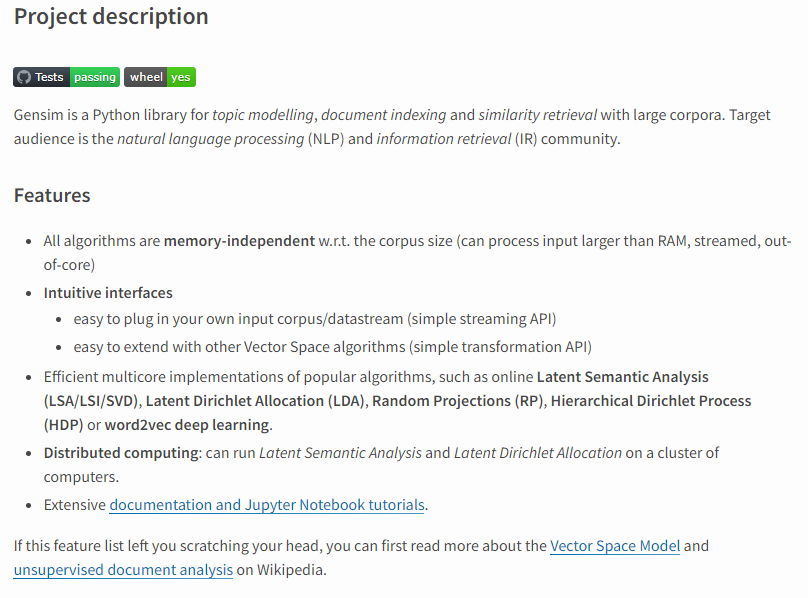

In [70]:
# pip install gensim

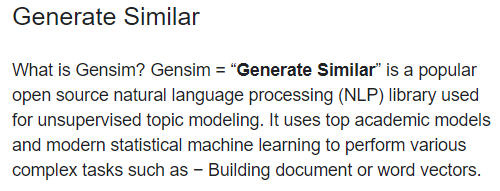

In [5]:
#for word embedding

# The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text. Once trained, such 
# a model can detect synonymous words or suggest additional words for a partial sentence.

import gensim
from gensim.models import Word2Vec # The purpose and usefulness of Word2vec is to group the vectors of similar words 
                                   # together in vectorspace. Word2Vec runs on tokenized sentence

### Loading the data set & EDA

In [9]:
df_train= pd.read_csv('d:/data/tweet/train.csv')
df_test=pd.read_csv('d:/data/tweet/test.csv')

In [10]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


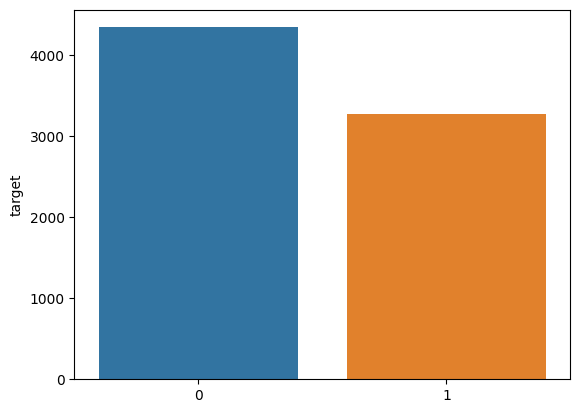

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_train is your DataFrame
x = df_train['target'].value_counts()

# Create a bar plot
sns.barplot(x=x.index, y=x)

# Show the plot
plt.show()

# We have 7,613 tweets in training (labelled) dataset and 3,271 in the test(unlabelled) dataset. 
# Here’s a snapshot of the training/labelled dataset which we’ll use for building our model

In [24]:
print(x)

0    4342
1    3271
Name: target, dtype: int64


In [15]:
df_train.isna().sum()

# Missing values: We have ~2.5k missing values in location field and 61 missing values in keyword column

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [16]:
# WORD-COUNT
# Number of words in a tweet: Disaster tweets are more wordy than the non-disaster tweets

df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))

print(df_train[df_train['target']==1]['word_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==0]['word_count'].mean()) #Non-Disaster tweets

# The average number of words in a disaster tweet is 15.17 as compared to an average of 14.7 words in a non-disaster tweet
# Number of words in a tweet: Disaster tweets are more wordy than the non-disaster tweets

15.167532864567411
14.704744357438969


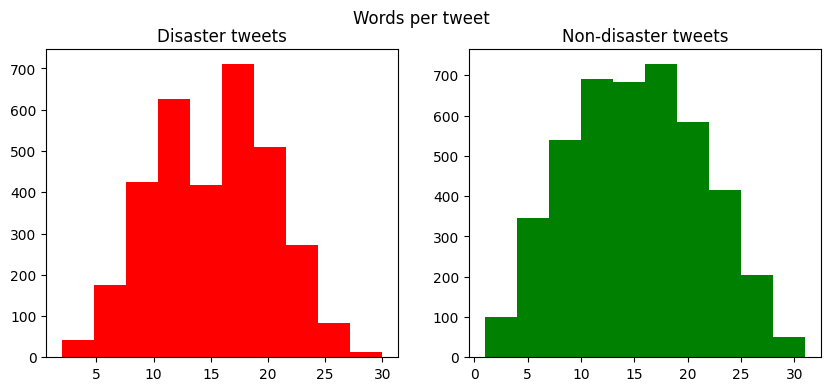

In [25]:
import matplotlib.pyplot as plt

# PLOTTING WORD-COUNT

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')
train_words=df_train[df_train['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

In [26]:
# Number of characters in a tweet: Disaster tweets are longer than the non-disaster tweets

# CHARACTER-COUNT

df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print(df_train[df_train['target']==1]['char_count'].mean()) #Disaster tweets
print(df_train[df_train['target']==0]['char_count'].mean()) #Non-Disaster tweets

# The average characters in a disaster tweet is 108.1 as compared to an average of 95.7 characters in a non-disaster tweet

108.11342097217977
95.70681713496084


### Text Pre-Processing

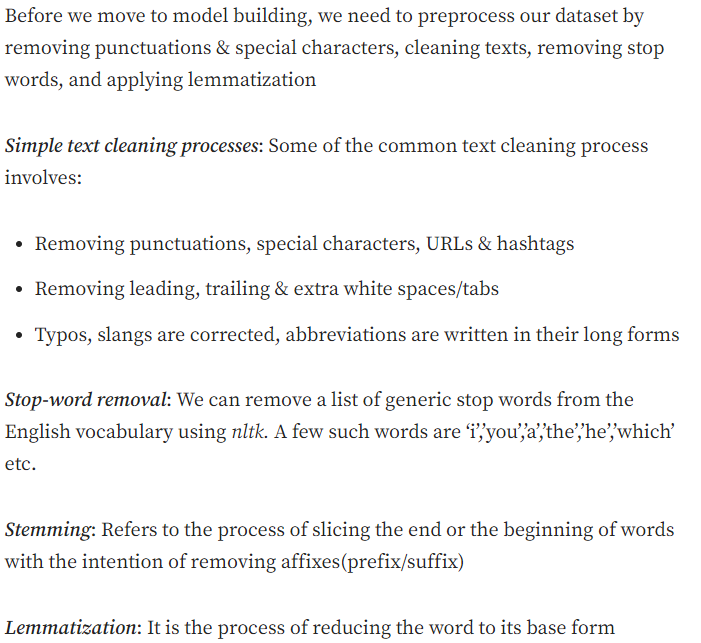

In [19]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [20]:
# Final pre-processing

def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train.head()

,id,keyword,location,text,target,word_count,char_count,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,133,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,get sent photo ruby alaska smoke wildfires pou...


### Extracting vectors from text (Vectorization)

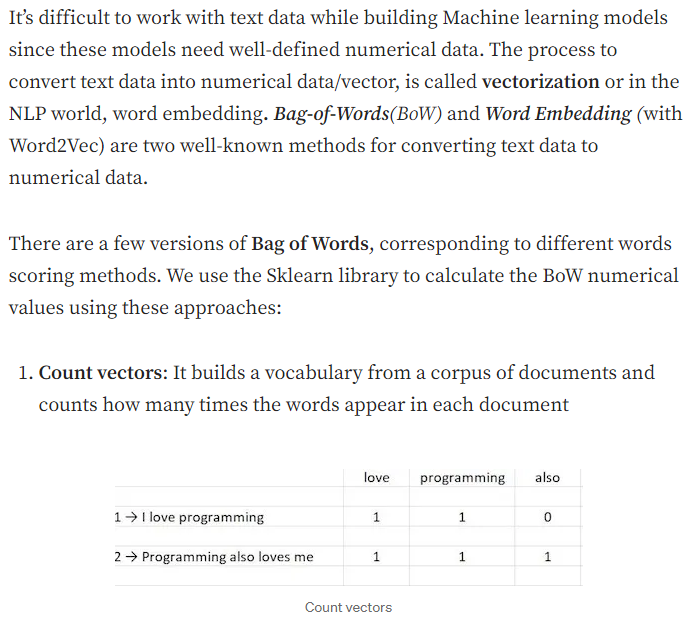

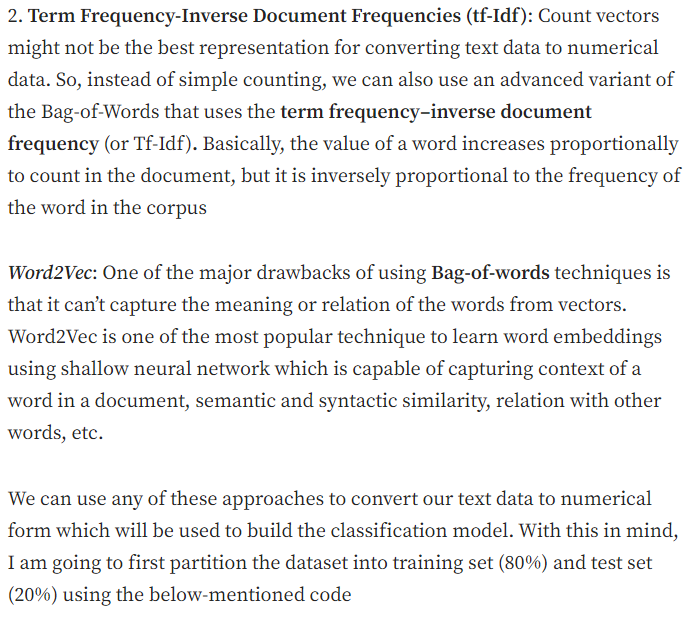

In [27]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(df_train["clean_text"],df_train["target"],test_size=0.2,shuffle=True)

#Word2Vec
# Word2Vec runs on tokenized sentences

X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [28]:
X_train_tok

[['slam',
  'door',
  'lesson',
  'learn',
  'let',
  'another',
  'lover',
  'crash',
  'burn'],
 ['leedsrouge',
  'love',
  'pick',
  'play',
  'worth',
  'fifth',
  'harm',
  'kid',
  'ink',
  'listen',
  'amp',
  'vote',
  'http',
  'co',
  'wratka',
  'jl'],
 ['kijima',
  'matako',
  'break',
  'news',
  'unconfirmed',
  'heard',
  'loud',
  'bang',
  'nearby',
  'appear',
  'blast',
  'wind',
  'neighbour',
  'as'],
 ['drop', 'fire', 'selfie', 'tomorrow', 'say', 'welcome', 'ahead', 'time'],
 ['alanhahn',
  'hdumpty',
  'daughtery',
  'would',
  'get',
  'destroyed',
  'twitter',
  'comment',
  'emotionally',
  'driven',
  'rant',
  'little',
  'factual',
  'basis'],
 ['kiwi',
  'karyn',
  'check',
  'parking',
  'lot',
  'say',
  'last',
  'year',
  'ambulance',
  'st',
  'john',
  'http',
  'co',
  'hpvodud',
  'ip'],
 ['ohhmyjoshh',
  'stevenrulles',
  'gon',
  'na',
  'think',
  'get',
  'shit',
  'wreck',
  'first',
  'day',
  'school'],
 ['inundate',
  'employee',
  'holiday

In [29]:
X_test_tok

[['campsite',
  'recommendation',
  'toilet',
  'shower',
  'pub',
  'fire',
  'kid',
  'pizza',
  'shop',
  'forest',
  'pretty',
  'stream',
  'midge',
  'snake',
  'thanks'],
 ['come',
  'back',
  'camp',
  'return',
  'new',
  'song',
  'get',
  'record',
  'tomorrow',
  'wait',
  'desolation',
  'theconspiracytheory',
  'newep'],
 ['new',
  'explosion',
  'proof',
  'temper',
  'glass',
  'screen',
  'protector',
  'film',
  'blackberry',
  'z',
  'full',
  'read',
  'byû',
  'http',
  'co',
  'toyu',
  'mxbo',
  'http',
  'co',
  'p',
  'hndc',
  'mm'],
 ['potus',
  'strategicpatience',
  'strategy',
  'genocide',
  'refugees',
  'idp',
  'internally',
  'displaced',
  'people',
  'horror',
  'etc',
  'http',
  'co',
  'owc',
  'fmbr'],
 ['week',
  'whirlwind',
  'exactly',
  'imagine',
  'nyc',
  'version',
  'career',
  'like'],
 ['drown', 'actavis', 'suicide'],
 ['bluedio',
  'turbine',
  'hurricane',
  'h',
  'bluetooth',
  'wireless',
  'stereo',
  'headphone',
  'headset',


In [40]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       888
           1       0.75      0.74      0.75       635

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.79      0.79      0.79      1523

Confusion Matrix: [[735 153]
 [164 471]]
AUC: 0.8584574732212529


In [41]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       888
           1       0.84      0.68      0.75       635

    accuracy                           0.81      1523
   macro avg       0.82      0.79      0.80      1523
weighted avg       0.81      0.81      0.81      1523

Confusion Matrix: [[805  83]
 [205 430]]
AUC: 0.8634869121089593


In [39]:
# You can now select the best model (lr_tfidf in our case) to estimate ‘target’ values for the unlabelled dataset (df_test).


#Pre-processing the new dataset
df_test['clean_text'] = df_test['text'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_text'] 

#converting words to numerical data using tf-idf
X_vector=tfidf_vectorizer.transform(X_test)

#use the best model to predict 'target' value for the new dataset 
y_predict = lr_tfidf.predict(X_vector)      
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
df_test['predict_prob']= y_prob
df_test['target']= y_predict
final=df_test[['clean_text','target']].reset_index(drop=True)
print(final.head())

                                          clean_text  target
0                          happen terrible car crash       1
1  heard earthquake different city stay safe ever...       1
2  forest fire spot pond geese flee across street...       1
3                  apocalypse light spokane wildfire       1
4                 typhoon soudelor kill china taiwan       1
